In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [14]:
actions = [
    'hospital',
    'doctor',
    'medicine',
    'cough',
    'runnynose',
    'painful'
]

data = np.concatenate([
    np.load('dataset/seq_hospital_1718895108.npy'),
    np.load('dataset/seq_doctor_1718895108.npy'),
    np.load('dataset/seq_medicine_1718895108.npy'),
    np.load('dataset/seq_cough_1718895108.npy'),
    np.load('dataset/seq_runnynose_1718895108.npy'),
    np.load('dataset/seq_painful_1718895108.npy')
], axis=0)

data.shape

(5034, 30, 198)

In [20]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(5034, 30, 197)
(5034,)


In [28]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# labels를 정수형으로 변환하고, 범위를 벗어나는 값 제거
# Filter out invalid labels and ensure they are integers within range
valid_indices = [i for i, label in enumerate(labels) if int(label) < len(actions) and int(label) >= 0]
labels = np.array([int(labels[i]) for i in valid_indices])
x_data = x_data[valid_indices]

# 차원 맞추기 (예: 198 -> 199으로 확장)
x_data = np.pad(x_data, ((0,0), (0,0), (0,1)), 'constant')
print(f'x_data shape after padding: {x_data.shape}')

# One-hot encoding
y_data = to_categorical(labels, num_classes=len(actions))
print("Y data shape: ", y_data.shape)


x_data shape after padding: (3501, 30, 199)
Y data shape:  (3501, 6)


In [29]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)



from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3150, 30, 199) (3150, 6)
(351, 30, 199) (351, 6)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model = Sequential([
    LSTM(64, activation='relu', input_shape=(30, 199)),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,862 (272.90 KB)

 Trainable params: 69,862 (272.90 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model3.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)



Epoch 1/200
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5201 - loss: 28.6996
Epoch 1: val_acc improved from -inf to 0.68946, saving model to models/model3.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.5284 - loss: 27.8170 - val_acc: 0.6895 - val_loss: 8.5123 - learning_rate: 0.0010
Epoch 2/200
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6761 - loss: 9.0603
Epoch 2: val_acc did not improve from 0.68946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.6757 - loss: 9.2163 - val_acc: 0.6638 - val_loss: 9.8626 - learning_rate: 0.0010
Epoch 3/200
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.6484 - loss: 10.4003
Epoch 3: val_acc did not improve from 0.68946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.6478 - loss: 10.4244 - val_acc: 0.6125 - val_loss: 13.4592 - learning_rate: 0.0010
Epoch 4/200
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5852 - loss: 9.9342 
Epoch 4: val_acc did not improve from 0.68946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.5847 - loss: 9.79

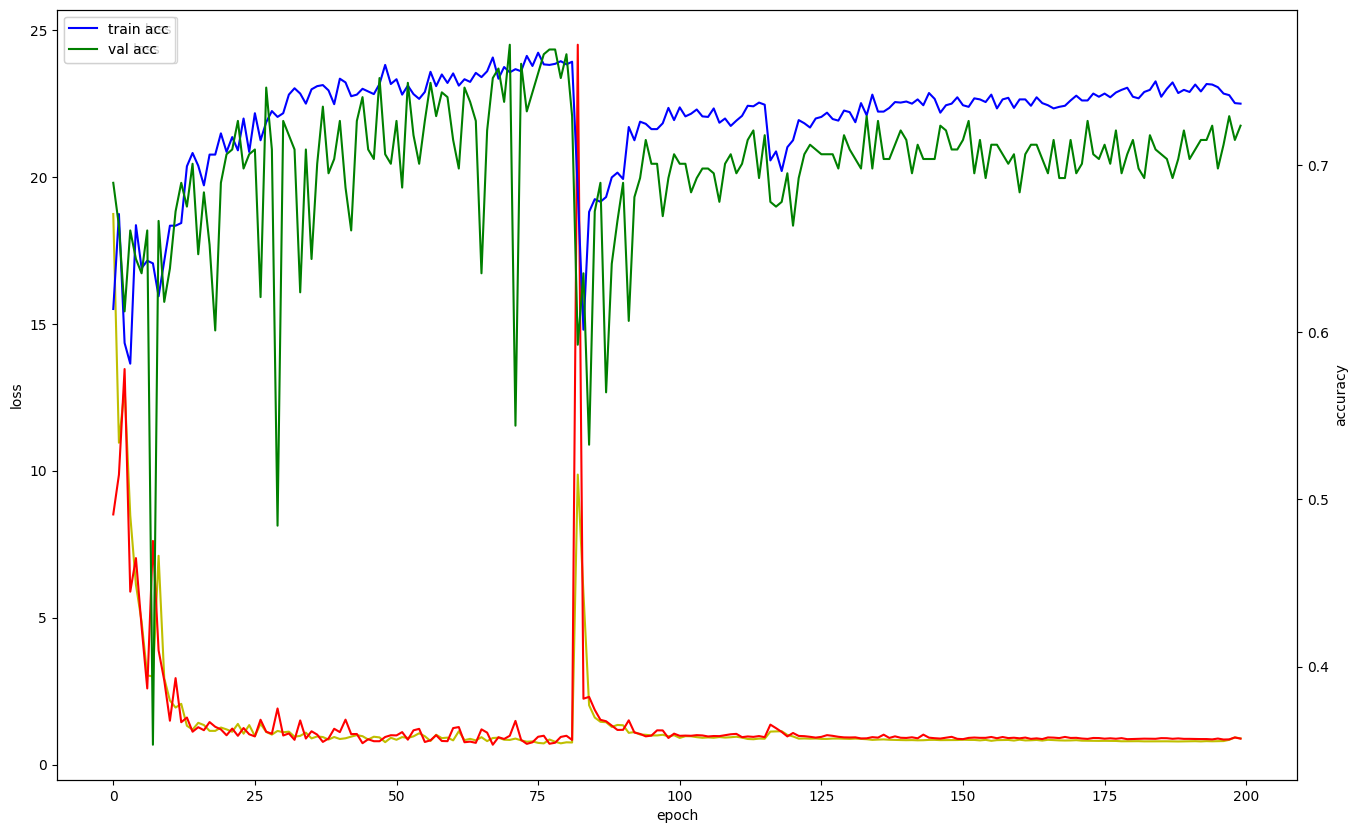

In [32]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [33]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model2.keras')  # 확장자를 .keras로 변경

y_pred = model.predict(x_val)

confusion_matrix = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
print(confusion_matrix)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[[ 41  73]
  [159  78]]

 [[305  39]
  [  6   1]]

 [[179 150]
  [ 12  10]]

 [[317   0]
  [ 34   0]]

 [[321   0]
  [ 30   0]]

 [[330   0]
  [ 21   0]]]
